# Measure properties of M1-67 globules from HST H alpha images

## Install and import packages

In [ ]:
!pip install astroquery cmasher --quiet

In [ ]:
from astroquery.mast import Observations
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS

from matplotlib import pyplot as plt
import seaborn as sn
sn.set_context("notebook")
import cmasher as cm

## Download data from MAST archive

Get a list of all the dtatsets that have been processed by the Hubble Legacy Archive and that use the Ha filter.

*Note that the older instruments like WFPC2 are not available from Amazon AWS, so we need to get the data directly from the archive.*

In [ ]:
table = Observations.query_criteria(
    objectname="WR124", 
    radius="1 arcmin",
    filters=["F656N"],
    project="HLA",
    )
table.remove_column("s_region")

In [ ]:
table

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID,objID1,distance
str5,int64,str3,str39,str10,float64,float64,float64,float64,float64,str7,str17,float64,float64,str1,str1,float64,str9,str6,str5,str3,str3,int64,str3,str175,str176,str6,bool,float64,str7,str8,str8,str8,float64
image,3,HLA,hst_06787_01_wfpc2_f656n_pc,PK050+03D1,287.8680820163602,16.861139634877297,50523.49219,50523.77734,10216.0,OPTICAL,F656N,655299987792.9688,657460021972.6562,--,--,50889.27368054,WFPC2/PC,MOFFAT,6787,HLA,HLA,--,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_06787_01_wfpc2_f656n_pc,https://hla.stsci.edu/cgi-bin/getdata.cgi?dataset=hst_06787_01_wfpc2_f656n_pc_drz.fits,PUBLIC,--,nan,science,25602505,67526819,67526819,10.693224856847792
image,3,HLA,hst_11137_01_wfpc2_f656n_pc,WR124,287.87609821697606,16.85152248850094,54638.65367,54638.75043,4200.0,OPTICAL,F656N,655299987792.9688,657460021972.6562,--,--,55003.87702537,WFPC2/PC,MOFFAT,11137,HLA,HLA,--,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_11137_01_wfpc2_f656n_pc,https://hla.stsci.edu/cgi-bin/getdata.cgi?dataset=hst_11137_01_wfpc2_f656n_pc_drz.fits,PUBLIC,--,nan,science,25724916,67649230,67649230,10.244428750365518
IMAGE,3,HLA,hst_06787_01_wfpc2_f675w_f656n_f555w_pc,PK050+03D1,287.8680725097656,16.861112594604492,nan,nan,10456.4599609375,OPTICAL,F675W;F656N;F555W,nan,nan,--,--,50888.57870358,WFPC2/PC,MOFFAT,6787,HLA,HLA,--,HLA,http://hla.stsci.edu/cgi-bin/fitscut.cgi?red=hst_06787_01_wfpc2_f675w_pc&amp;green=hst_06787_01_wfpc2_f656n_pc&amp;blue=hst_06787_01_wfpc2_f555w_pc&amp;size=ALL&amp;format=jpg,http://hla.stsci.edu/cgi-bin/fitscut.cgi?red=hst_06787_01_wfpc2_f675w_pc&amp;green=hst_06787_01_wfpc2_f656n_pc&amp;blue=hst_06787_01_wfpc2_f555w_pc&amp;size=ALL&amp;format=fits,PUBLIC,--,nan,science,26152133,68226608,68226608,10.693224856847792
IMAGE,3,HLA,hst_06787_01_wfpc2_f675w_f656n_f555w_wf,PK050+03D1,287.8815612792969,16.86099624633789,nan,nan,10456.4599609375,OPTICAL,F675W;F656N;F555W,nan,nan,--,--,50888.57870358,WFPC2/WFC,MOFFAT,6787,HLA,HLA,--,HLA,http://hla.stsci.edu/cgi-bin/fitscut.cgi?red=hst_06787_01_wfpc2_f675w_wf&amp;green=hst_06787_01_wfpc2_f656n_wf&amp;blue=hst_06787_01_wfpc2_f555w_wf&amp;size=ALL&amp;format=jpg,http://hla.stsci.edu/cgi-bin/fitscut.cgi?red=hst_06787_01_wfpc2_f675w_wf&amp;green=hst_06787_01_wfpc2_f656n_wf&amp;blue=hst_06787_01_wfpc2_f555w_wf&amp;size=ALL&amp;format=fits,PUBLIC,--,nan,science,26152134,68226609,68226609,0.0
image,3,HLA,hst_06787_01_wfpc2_f656n_wf,PK050+03D1,287.87476345420487,16.86723413060137,50523.49219,50523.77734,10216.0,OPTICAL,F656N,655299987792.9688,657460021972.6562,--,--,50889.27368054,WFPC2/WFC,MOFFAT,6787,HLA,HLA,--,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_06787_01_wfpc2_f656n_wf,https://hla.stsci.edu/cgi-bin/getdata.cgi?dataset=hst_06787_01_wfpc2_f656n_wf_drz.fits,PUBLIC,--,517.0,science,25602506,67526820,67526820,0.0
image,3,HLA,hst_11137_01_wfpc2_f656n_wf,WR124,287.8809628974585,16.85790240304982,54638.65367,54638.75043,4200.0,OPTICAL,F656N,655299987792.9688,657460021972.6562,--,--,55003.87702537,WFPC2/WFC,MOFFAT,11137,HLA,HLA,--,HLA,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_11137_01_wfpc2_f656n_wf,https://hla.stsci.edu/cgi-bin/getdata.cgi?dataset=hst_11137_01_wfpc2_f656n_wf_drz.fits,PUBLIC,--,5279.0,science,25724917,67649231,67649231,0.0


To start with, we will just use the WFC image from the second epoch 

In [ ]:
products = Observations.get_product_list(table)

And we only want the final drizzled images

In [ ]:
filtered = Observations.filter_products(products,
                                        obs_id="hst_11137_01_wfpc2_f656n_wf",
                                        productSubGroupDescription='DRZ')

In [ ]:
filtered

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str39,str67,str1,str168,str9,str28,str7,str1,str8,str19,str5,str48,int64,str8,str6,int64
25724917,HLA,image,hst_11137_01_wfpc2_f656n_wf,HLA simple fits science image,C,mast:HLA/url/cgi-bin/getdata.cgi?dataset=hst_11137_01_wfpc2_f656n_wf_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,HLA,--,11137,hst_11137_01_wfpc2_f656n_wf_drz.fits,55607040,25724917,PUBLIC,3


The first file is the one we want:

In [ ]:
manifest = Observations.download_products(filtered[0], productType="SCIENCE")

In [ ]:
manifest

Local Path,Status,Message,URL
str83,str8,object,object
./mastDownload/HLA/hst_11137_01_wfpc2_f656n_wf/hst_11137_01_wfpc2_f656n_wf_drz.fits,COMPLETE,None,None


In [ ]:
fn = manifest[0]["Local Path"]

In [ ]:
hdulist = fits.open(fn)
hdulist.info()

Filename: ./mastDownload/HLA/hst_11137_01_wfpc2_f656n_wf/hst_11137_01_wfpc2_f656n_wf_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1194   ()      
  1  SCI           1 ImageHDU       103   (2150, 2150)   float32   
  2  WHT           1 ImageHDU       124   (2150, 2150)   float32   
  3  CTX           1 ImageHDU       123   (2150, 2150)   int32   


## Plot image of data

In [ ]:
hdu = hdulist['SCI']
wcs = WCS(hdu)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 287.8782164216667  16.86331641638889  
CRPIX : 1075.0  1075.0  
CD1_1 CD1_2  : -2.777777777777778e-05  0.0  
CD2_1 CD2_2  : 0.0  2.777777777777778e-05  
NAXIS : 2150  2150

In [ ]:
import numpy as np
from astropy.visualization import simple_norm
from astropy.coordinates import SkyCoord

Get celestial coordinates of central WR star

In [ ]:
c0 = SkyCoord.from_name('wr124')
c0

<SkyCoord (ICRS): (ra, dec) in deg
    (287.87864549, 16.86061137)>

Convert to pixel coordinates and define the size of the window we want to plot (in pixels, which are  0.1 arcsec)

In [ ]:
x0, y0 = wcs.world_to_pixel(c0)
mx, my = 600, 600

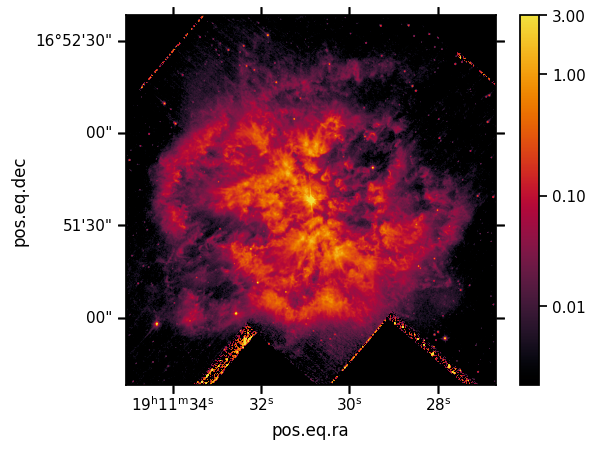

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=wcs)
norm = simple_norm(hdu.data, stretch='log', min_cut=0, max_cut=3)
im = ax.imshow(hdu.data, norm=norm, cmap=cm.ember)
cb = fig.colorbar(im, ax=ax, ticks=[0.01, 0.1, 1.0, 3.0])
ax.set(
    xlim=[x0 - mx, x0 + mx],
    ylim=[y0 - my, y0 + my],
)
...;

## Plot brightness versus radius

Get the angular separation of each image pixel from the central star

In [ ]:
ny, nx = hdu.data.shape
xpix, ypix = np.meshgrid(np.arange(nx), np.arange(ny))
pixcoords = wcs.pixel_to_world(xpix, ypix)
seps = c0.separation(pixcoords)
seps.arcsec.min(), seps.arcsec.max()

(0.04392998540547969, 160.06571401566916)

In [ ]:
goodpixels = hdu.data > 0.0
radius = seps.arcsec[goodpixels]
brightness = hdu.data[goodpixels]

In [ ]:
brightness.min(), brightness.max()

(1.3422259e-08, 4471.7876)

Make a histogram of the radius and brightness on a log scale.

In [ ]:
rmin, rmax = 0.5, 1.02 * radius.max()
bmin, bmax = 0.001, 5.0
ymin, ymax = np.log10(bmin), np.log10(bmax)
xmin, xmax = np.log10(rmin), np.log10(rmax)
H, yedges, xedges = np.histogram2d(
    np.log10(brightness),
    np.log10(radius),
    bins=300,
    range=[[ymin, ymax], [xmin, xmax]],
    weights=brightness,
    density=True,
)
H.sum() * (ymax - ymin) * (xmax - xmin) / np.product(H.shape)


1.0

In [ ]:
HH = np.where(H == 0.0, np.nan, H)

In [ ]:
from matplotlib.colors import PowerNorm

And plot the histogram.

[Text(0.5, 0, '$\\log_{10}$ (Separation, arcsec)'),
 Text(0, 0.5, '$\\log_{10}$ (Brightness)'),
 Text(0.5, 1.0, 'M1-67 – histogram version')]

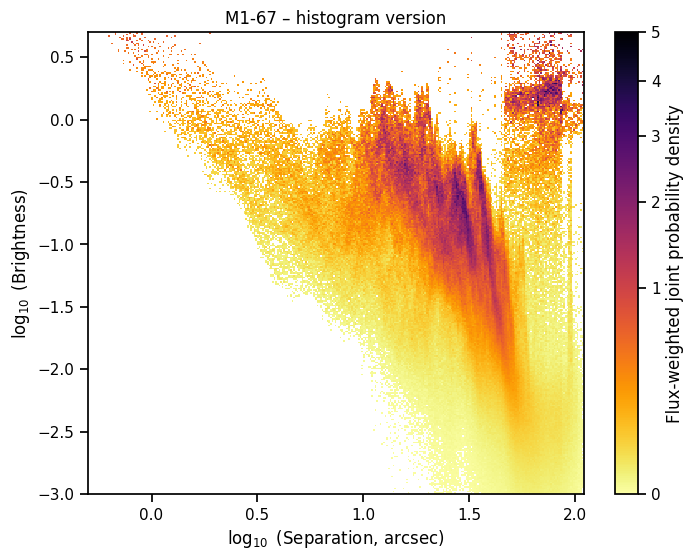

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    HH, 
    origin="lower", 
    norm=PowerNorm(gamma=0.5, vmin=0.0, vmax=5),
    cmap="inferno_r", 
    extent=[xmin, xmax, ymin, ymax], 
    aspect="auto",
    interpolation="none",
)

fig.colorbar(im, ax=ax, label="Flux-weighted joint probability density")
ax.set(
    xlabel=r'$\log_{10}$ (Separation, arcsec)',
    ylabel=r'$\log_{10}$ (Brightness)',
    title=f"M1-67 – histogram version",
)
...;

Note that we have a bunch of spurious bright pixels for radii > 45

In [ ]:
badpix = (radius > 45.0) & (brightness > 0.3)
brightness[badpix] = np.nan

Now do the same but with a linear radius scale and a sqrt brightness scale. 

In [ ]:
rmin, rmax = 0.0, 70.0
bmin, bmax = 0.0, 4.0
ymin, ymax = np.sqrt(bmin), np.sqrt(bmax)
xmin, xmax = rmin, rmax
H, yedges, xedges = np.histogram2d(
    np.sqrt(brightness),
    radius,
    bins=(100, 200),
    range=[[ymin, ymax], [xmin, xmax]],
    weights=brightness,
    density=True,
)
H.sum() * (ymax - ymin) * (xmax - xmin) / np.product(H.shape)


1.0

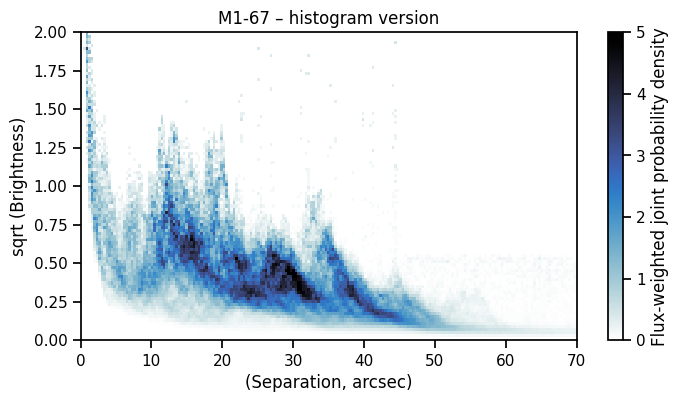

In [ ]:
HH = np.where(H == 0.0, np.nan, H)
HH /= np.nansum(HH) / np.isfinite(HH).sum()
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(
    HH, 
    origin="lower", 
    norm=PowerNorm(gamma=1.0, vmin=0.0, vmax=5.0),
    cmap=cm.arctic_r,
    extent=[xmin, xmax, ymin, ymax], 
    aspect="auto",
    interpolation="none",
)

fig.colorbar(im, ax=ax, label="Flux-weighted joint probability density")
ax.set(
    xlabel=r'(Separation, arcsec)',
    ylabel=r'sqrt (Brightness)',
    title=f"M1-67 – histogram version",
)
...;

This shows the structure much better. We see the multiple shells in the nebula. The color is proprtional to the fraction of the total nebular emission that comes from that cobination of suface brightness and radius. This tends to be maximum for the median brightness, but the peak brightnesses are also a significant fraction (but never a majority)
                                            

## Look at the globules